# Titanic Survival Analysis ---- My First Notebook

Kaggle Competition For Starters: https://www.kaggle.com/c/titanic

In [5]:
# Import packages: numpy, pandas, matplotlib, seaborn, scikit-learn
import numpy as np
import pandas as pd
from pandas import Series
from pandas import DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
###? sns.set_style('whitegrid')
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [6]:
# Import CSV to Dateframe
titanic_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# First glance at the datasets
titanic_df.head()
titanic_df.describe()
###titanic_df.info()

test_df.head()
test_df.describe()
###test_df.info()

##### from info we can know: 
#####1, missing values: train_df-Age,Carbin,Embarked / test_df-Age,Fare,Cabin -- Deal with missing values
#####2, object variables include: Name, Sex, Ticket, Carbin, Embarked -- Need transformation to numbers 

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [7]:
################################## Data cleaning 

# Drop unnesscary varibles for analysis and prediction
titanic_df = titanic_df.drop(['Name','Ticket'], axis=1)
###?or: titanic_df = titanic_df.drop(columns=['Name', 'Ticket'])
test_df = test_df.drop(['Name', 'Ticket'], axis=1)

In [8]:
#Deal with missing values

### check missing values in datasets
titanic_df.isnull().sum()
test_df.isnull().sum()

### Missing values in Embarked(only in train_df) ---- replace with mode
##### missing rows: print(titanic_df.Embarked[titanic_df.Embarked.isnull()])
##### Embarked is an object ---- '.values'
titanic_df.Embarked[titanic_df.Embarked.isnull()] = titanic_df.Embarked.dropna().mode().values

### Missing values in Fare(only in test_df) ---- replace with median
##### missing rows:print(test_df.Fare[test_df.Fare.isnull()])
test_df.Fare[test_df.Fare.isnull()] = test_df.Fare.dropna().median()

### Missing values in Cabin ---- replace with "c0"/delete
######Method 1:a big number of missing values in Cabin; missing values might represent people without a cabin
    ####### titanic_df.Cabin[titanic_df.Cabin.isnull()] = 'c0'
    ####### test_df.Cabin[test_df.Cabin.isnull()] = 'c0'
#####Method 2:a big number of missing values in Cabin might impact prediction accuracy----delete variable
titanic_df = titanic_df.drop(['Cabin'], axis=1)
test_df = test_df.drop(['Cabin'], axis=1)

C:\Users\mibiy\Anaconda2\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\mibiy\Anaconda2\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [9]:
### Missing values in Age ---- replace with random forest prediction values
###### Age is an important attribute in the final prediction, thus its accuracy needs to be high
#choose training data to predict age
age_df = titanic_df[['Age', 'Survived', 'SibSp', 'Parch', 'Fare', 'Pclass']]
age_df_isnull = age_df.loc[(titanic_df.Age.isnull())]
age_df_notnull = age_df.loc[(titanic_df.Age.notnull())]
X = age_df_notnull.values[ : , 1 : ]
Y = age_df_notnull.values[ : , 0 ]
###print(X)
###print(Y)

#use random forest to train data
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(n_estimators=1000,n_jobs=-1)
rfr.fit(X,Y)
predict_age = rfr.predict(age_df_isnull.values[:,1:])
titanic_df.loc[(titanic_df.Age.isnull()),'Age'] = predict_age

#use the same method to predict missing values of age in test data
age_df_test = test_df[['Age', 'SibSp', 'Parch', 'Fare', 'Pclass']]
age_df_isnull_test = age_df_test.loc[(test_df.Age.isnull())]
age_df_notnull_test = age_df_test.loc[(test_df.Age.notnull())]
X_test = age_df_notnull_test.values[ : , 1 : ]
Y_test = age_df_notnull_test.values[ : , 0 ]

rfr_test = RandomForestRegressor(n_estimators=1000,n_jobs=-1)
rfr_test.fit(X_test,Y_test)
predict_age_test = rfr_test.predict(age_df_isnull_test.values[:,1:])
test_df.loc[(test_df.Age.isnull()),'Age'] = predict_age_test

In [10]:
# convert float variables to int

### Fare
titanic_df['Fare'] = titanic_df['Fare'].astype(int)
test_df['Fare']    = test_df['Fare'].astype(int)

### Age
titanic_df['Age'] = titanic_df['Age'].astype(int)
test_df['Age']    = test_df['Age'].astype(int)

In [11]:
########################################Create New Variables

# Create a new categorical variable ‘Alone' for passengers who travel alone
titanic_df['Family']=titanic_df["SibSp"]+titanic_df["Parch"]
titanic_df['Alone']=np.where(titanic_df['Family']>0, 0, 1)

titanic_df.drop('SibSp', axis=1, inplace=True)
titanic_df.drop('Parch', axis=1, inplace=True)
titanic_df.drop('Family', axis=1, inplace=True)

test_df['Family']=test_df["SibSp"]+test_df["Parch"]
test_df['Alone']=np.where(test_df['Family']>0, 0, 1)

test_df.drop('SibSp', axis=1, inplace=True)
test_df.drop('Parch', axis=1, inplace=True)
test_df.drop('Family', axis=1, inplace=True)

In [12]:
# Create a new categorical variable ‘Minor' for passengers who are younger than 16
titanic_df['Minor']=np.where(titanic_df['Age']<=16, 1, 0)
test_df['Minor']=np.where(test_df['Age']<=16, 1, 0)

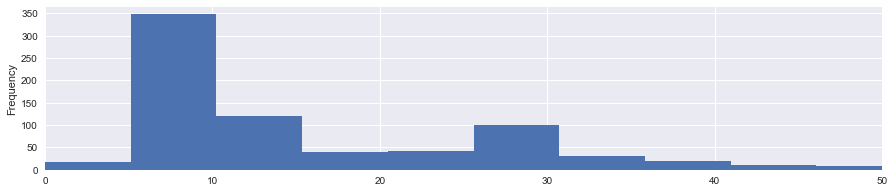

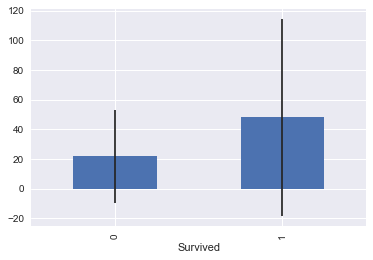

In [13]:
######################Data Eploration & Visualization

# Fare
fare_notsurvived = titanic_df["Fare"][titanic_df["Survived"] == 0]
fare_survived     = titanic_df["Fare"][titanic_df["Survived"] == 1]

avgerage_fare = DataFrame([fare_notsurvived.mean(), fare_survived.mean()])
std_fare      = DataFrame([fare_notsurvived.std(), fare_survived.std()])

titanic_df['Fare'].plot(kind='hist', figsize=(15,3),bins=100, xlim=(0,50))

avgerage_fare.index.names = std_fare.index.names = ["Survived"]
avgerage_fare.plot(yerr=std_fare,kind='bar',legend=False) 

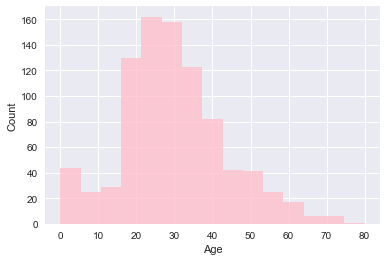

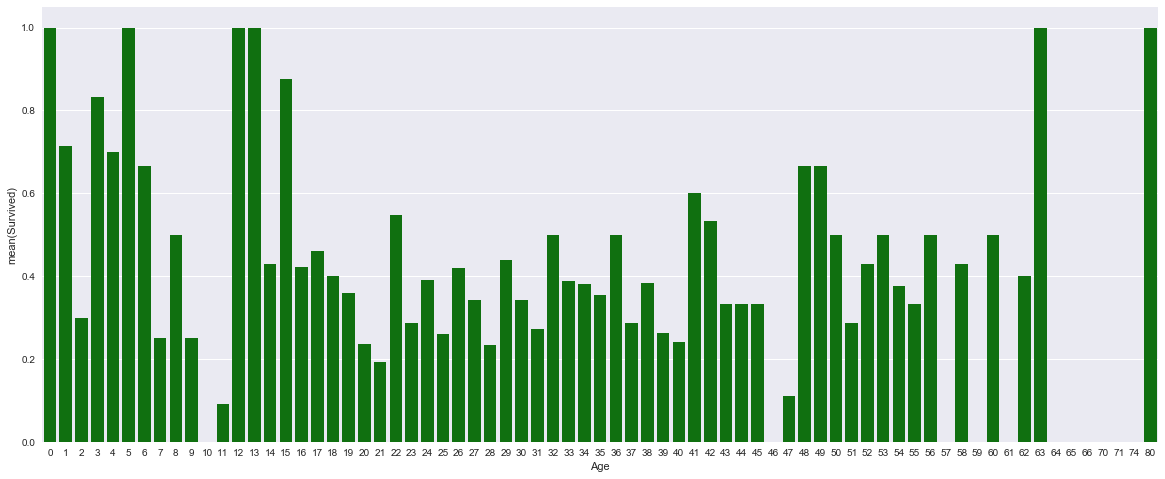

In [14]:
# Age
age_count = titanic_df["Age"].hist(bins=15, color='pink', alpha=0.8)
age_count.set(xlabel='Age', ylabel='Count')
plt.show()

plt.figure(figsize=(20,8))
age_survival = titanic_df[["Age", "Survived"]].groupby(['Age'],as_index=False).mean()
sns.barplot(x='Age', y='Survived', data=age_survival, color='green')

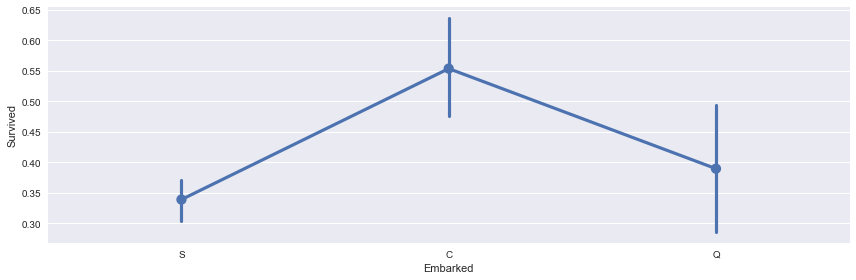

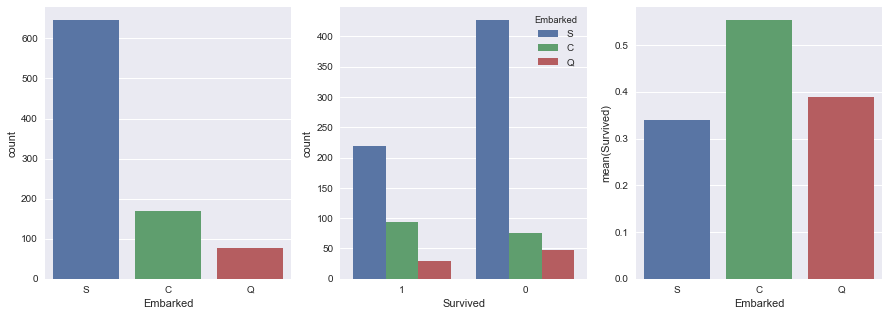

In [15]:
# Embarked
sns.factorplot('Embarked','Survived', data=titanic_df,size=4,aspect=3)
fig, (axis1,axis2,axis3) = plt.subplots(1,3,figsize=(15,5))

sns.countplot(x='Embarked', data=titanic_df, ax=axis1)
sns.countplot(x='Survived', hue="Embarked", data=titanic_df, order=[1,0], ax=axis2)

embark_perc = titanic_df[["Embarked", "Survived"]].groupby(['Embarked'],as_index=False).mean()
sns.barplot(x='Embarked', y='Survived', data=embark_perc,order=['S','C','Q'],ax=axis3)


[<matplotlib.text.Text at 0x15e4bd30>, <matplotlib.text.Text at 0x15d5d940>]

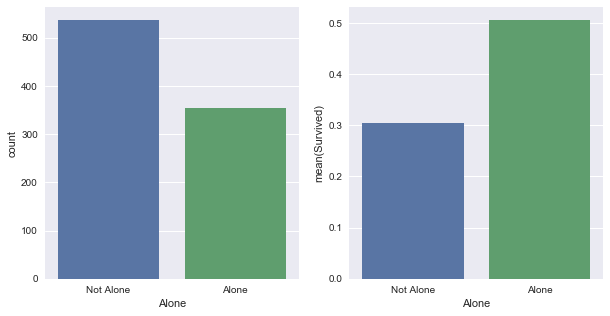

In [16]:
# Alone
fig, (axis1,axis2) = plt.subplots(1,2,sharex=True,figsize=(10,5))

#######sns.factorplot('Family',data=titanic_df,kind='count',ax=axis1)
sns.countplot(x='Alone', data=titanic_df, order=[1,0], ax=axis1)

Alone_perc = titanic_df[["Alone", "Survived"]].groupby(['Alone'],as_index=False).mean()
sns.barplot(x='Alone', y='Survived', data=Alone_perc, order=[1,0], ax=axis2)

axis1.set_xticklabels(["Not Alone","Alone"], rotation=0)

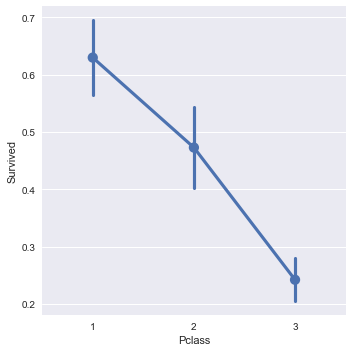

In [17]:
# Pclass
sns.factorplot('Pclass','Survived',order=[1,2,3], data=titanic_df,size=5)

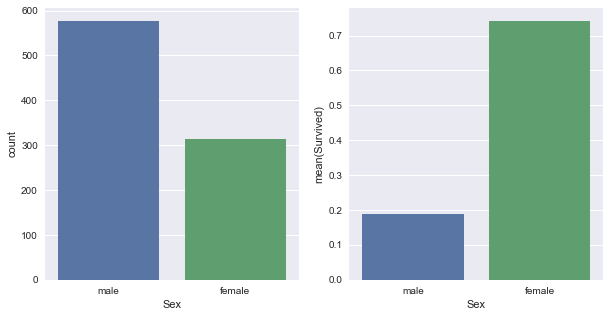

In [18]:
# Sex
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(10,5))
sns.countplot(x='Sex', data=titanic_df, ax=axis1)

sex_perc = titanic_df[["Sex", "Survived"]].groupby(['Sex'],as_index=False).mean()
sns.barplot(x='Sex', y='Survived', data=sex_perc, ax=axis2, order=['male','female'])

In [19]:
#####################################Predictive Modelling

#Create dummy variables for categorical variables

### dummies for Pclass
pclass_train = pd.get_dummies(titanic_df, columns=["Pclass"])
pclass_test = pd.get_dummies(test_df, columns=["Pclass"])

### dummies for Embarked
embarked_pclass_train = pd.get_dummies(pclass_train, columns=["Embarked"])
embarked_pclass_test = pd.get_dummies(pclass_test, columns=["Embarked"])

### dummies variable for Sex
fin_train=pd.get_dummies(embarked_pclass_train, columns=["Sex"])
fin_test=pd.get_dummies(embarked_pclass_test, columns=["Sex"])

### drop unnecessary columns
fin_train.drop('Sex_female', axis=1, inplace=True)
fin_train.drop('PassengerId', axis=1, inplace=True)
fin_test.drop('Sex_female', axis=1, inplace=True)

fin_train.head()
fin_test.head()

final_train = fin_train
final_test = fin_test

In [20]:
# define training and testing sets
final_train.head(20)

cols=["Age", "Fare", "Alone", "Pclass_1", "Pclass_2","Embarked_C","Embarked_S","Sex_male","Minor"] 
X_train=final_train[cols]
###### or: X_train = final_train.drop("Survived",axis=1)
Y_train = final_train['Survived']

In [21]:
# Logistci Regression
import statsmodels.api as sm
from scipy import stats

stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)
log_model=sm.Logit(Y_train,X_train)
result=log_model.fit()

print(result.summary())

C:\Users\mibiy\Anaconda2\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Optimization terminated successfully.
         Current function value: 0.449119
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                  891
Model:                          Logit   Df Residuals:                      882
Method:                           MLE   Df Model:                            8
Date:                Fri, 12 Jan 2018   Pseudo R-squ.:                  0.3256
Time:                        17:47:32   Log-Likelihood:                -400.16
converged:                       True   LL-Null:                       -593.33
                                        LLR p-value:                 1.573e-78
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Age           -0.0178      0.007     -2.436      0.015      -0.032      -0.003
Fare           0.0015      0.

In [22]:
columns_2=["Age", "Pclass_1", "Pclass_2","Embarked_C","Embarked_S","Sex_male"]  
X_train2=final_train[columns_2]

log_model2=sm.Logit(Y_train,X_train2)
result=log_model2.fit()

print(result.summary())

Optimization terminated successfully.
         Current function value: 0.455680
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                  891
Model:                          Logit   Df Residuals:                      885
Method:                           MLE   Df Model:                            5
Date:                Fri, 12 Jan 2018   Pseudo R-squ.:                  0.3157
Time:                        17:47:32   Log-Likelihood:                -406.01
converged:                       True   LL-Null:                       -593.33
                                        LLR p-value:                 8.675e-79
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Age           -0.0213      0.006     -3.420      0.001      -0.033      -0.009
Pclass_1       2.1887      0.

In [23]:
from sklearn.linear_model import LogisticRegression

log_model2 = LogisticRegression()
log_model2.fit(X_train2, Y_train)

log_model2.score(X_train2, Y_train)

0.7991021324354658

In [24]:
test_prediction = log_model2.predict(final_test[columns_2])

In [25]:
test_output = final_test['PassengerId']
submission = {
    'PassengerId': test_output,
    'Survived': test_prediction,
}
submission_df = pd.DataFrame(submission)
submission_file = submission_df.to_csv('ZimeiYangTitanicPrediction.csv', index=False)